# Deep learning tests

## Load libraries and data

In [2]:
import scipy.io as scio
from scipy.interpolate import CubicSpline
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model
import torch
import torch.nn
import torch.nn.functional
import torch.utils.data
import tqdm
from torchvision import datasets, transforms

data = scio.loadmat('tissue14.mat')
calibration = scio.loadmat('cal_14.mat')

In [ ]:
# Look at imported data
for key, value in data.items():
    try:
        print(key, value.shape)
    except:
        print(key, len(value))

In [3]:
target = data['tissue_t14_2']
tissue_data = data['map_t14_2'] 

## Visualise data 

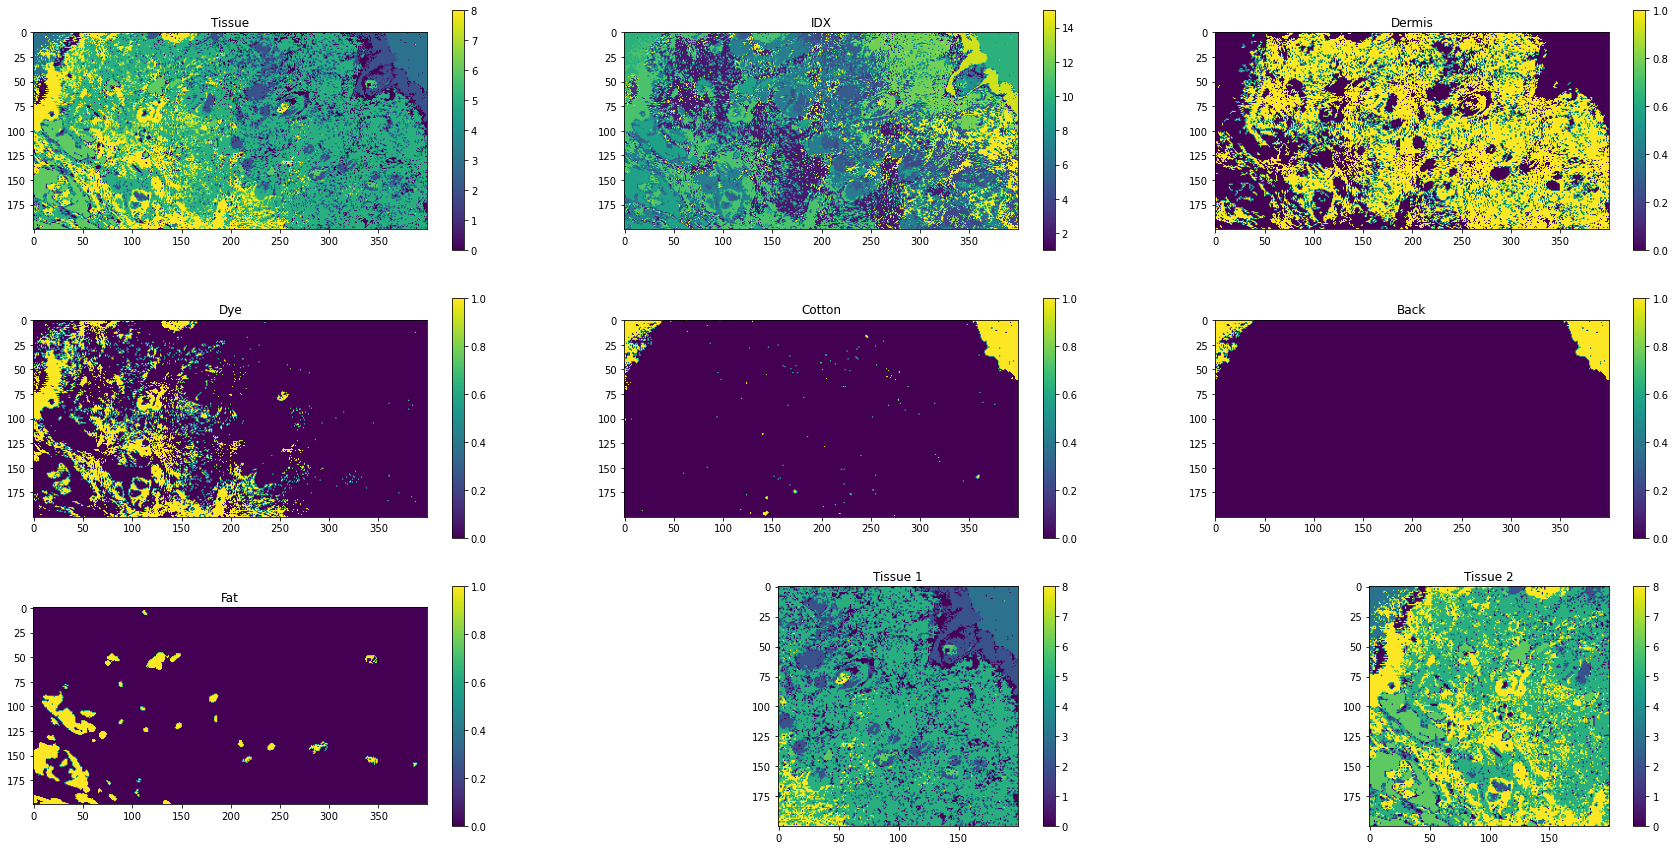

In [63]:
fig, axs = plt.subplots(3,3, figsize=(30,15))

im1 = axs[0,0].imshow(data['tissue_t14'])
fig.colorbar(im1, ax=axs[0,0])
axs[0,0].title.set_text('Tissue')

im2 = axs[0,1].imshow(data['IDX'])
fig.colorbar(im2, ax=axs[0,1])
axs[0,1].title.set_text('IDX')

im3 = axs[0,2].imshow(data['dermis'])
fig.colorbar(im3, ax=axs[0,2])
axs[0,2].title.set_text('Dermis')

im4 = axs[1,0].imshow(data['dye'])
fig.colorbar(im4, ax=axs[1,0])
axs[1,0].title.set_text('Dye')

im5 = axs[1,1].imshow(data['cotton'])
fig.colorbar(im5, ax=axs[1,1])
axs[1,1].title.set_text('Cotton')

im6 = axs[1,2].imshow(data['back'])
fig.colorbar(im6, ax=axs[1,2])
axs[1,2].title.set_text('Back')

im7 = axs[2,0].imshow(data['fat'])
fig.colorbar(im7, ax=axs[2,0])
axs[2,0].title.set_text('Fat')

im1 = axs[2,1].imshow(data['tissue_t14_1'])
fig.colorbar(im1, ax=axs[2,1])
axs[2,1].title.set_text('Tissue 1')

im1 = axs[2,2].imshow(data['tissue_t14_2'])
fig.colorbar(im1, ax=axs[2,2])
axs[2,2].title.set_text('Tissue 2')

## Get averaged data 

In [4]:
target_simple = target.copy()
for i in range(200):
    for j in range(200):
        if target[i,j] == 2:
            target_simple[i,j]=1
        if target[i,j] == 3:
            target_simple[i,j]=2
        if target[i,j] == 5:
            target_simple[i,j]=3
        if target[i,j] == 6:
            target_simple[i,j]=4
        if target[i,j] == 8:
            target_simple[i,j]=5

In [5]:
sub_images_4 = [] # list: 2500 x 4 x 4 x 1024
target_4 = np.zeros((50,50))

for i in range(50):
    for j in range(50):
        sub_image = tissue_data[i*4:(i+1)*4,j*4:(j+1)*4,:]
        sub_images_4.append(sub_image)

        array = target_simple[i*4:(i+1)*4,j*4:(j+1)*4].flatten()
        y = np.bincount(array)
        target_4[i,j] = np.argmax(y)

sub_images_2 = [] # list: 10000 x 2 x 2 x 1024
target_2 = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        sub_image = tissue_data[i*2:(i+1)*2,j*2:(j+1)*2,:]
        sub_images_2.append(sub_image)

        array = target_simple[i*2:(i+1)*2,j*2:(j+1)*2].flatten()
        y = np.bincount(array)
        target_2[i,j] = np.argmax(y)

In [26]:
data_2 = []

for i in range(10000):
    sample = []
    for j in range(1024):
        wave = np.zeros((2,2))
        wave[0,:] = [sub_images_2[i][0][0][j], sub_images_2[i][0][1][j]]
        wave[1,:] = [sub_images_2[i][1][0][j], sub_images_2[i][1][1][j]]
        sample.append(wave)
    data_2.append(sample)
    
    
data_4 = []

for i in range(2500):
    sample = []
    for j in range(1024):
        wave = np.zeros((4,4))
        wave[0,:] = [sub_images_4[i][0][0][j], sub_images_4[i][0][1][j], sub_images_4[i][0][2][j], sub_images_4[i][0][3][j]]
        wave[1,:] = [sub_images_4[i][1][0][j], sub_images_4[i][1][1][j], sub_images_4[i][1][2][j], sub_images_4[i][1][3][j]]
        wave[2,:] = [sub_images_4[i][2][0][j], sub_images_4[i][2][1][j], sub_images_4[i][2][2][j], sub_images_4[i][2][3][j]]
        wave[3,:] = [sub_images_4[i][3][0][j], sub_images_4[i][3][1][j], sub_images_4[i][3][2][j], sub_images_4[i][3][3][j]]
        sample.append(wave)
    data_4.append(sample)


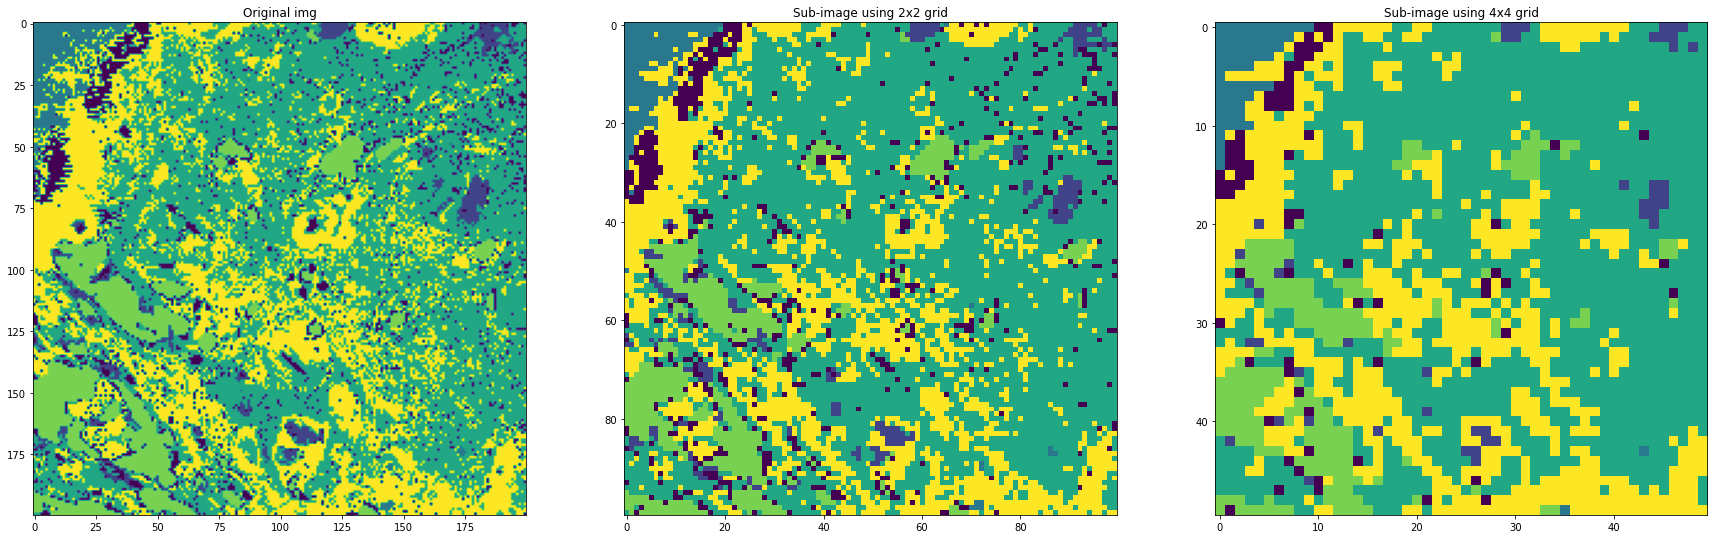

In [7]:
fig, axs = plt.subplots(1,3, figsize=(30,15))

axs[0].imshow(target_simple)
axs[0].title.set_text('Original img')

axs[1].imshow(target_2)
axs[1].title.set_text('Sub-image using 2x2 grid')

axs[2].imshow(target_4)
axs[2].title.set_text('Sub-image using 4x4 grid')


## Baseline removal

In [137]:
def remove_baseline(spectrum, window_size=64):
    """
    Use rubber-band method to remove baseline from spectrum
    Input:  - spectrum: np.array
            - window_size (optional): size of rubber-band window
    Output: - smoothed_spectrum: spectrum after baseline removal
    """
    spectrum_len = len(spectrum)  
    num_intervals = int(spectrum_len//window_size)
    
    # Get min value at each interval
    min_values = []
    min_indexes = []
    
    for k in range(int(num_intervals)):
        min_value = np.amax(spectrum[window_size*k : window_size*(k+1)])
        min_index = np.argmax(spectrum[window_size*k : window_size*(k+1)]) + window_size*k
        min_values.append(min_value)
        min_indexes.append(min_index)

    # Fit cubic spline
    cs = CubicSpline(min_indexes,min_values)

    # Remove spline from original spectrum
    smoothed_spectrum = np.zeros(spectrum_len)  
    for i in range(1024):
        smoothed_spectrum[i] = spectrum[i] - cs(i)
            
    return smoothed_spectrum
        

In [141]:
tissue_no_bl = tissue_data.copy()

for i in range(200):
    for j in range(200):
        tissue_no_bl[i,j,:] = remove_baseline(tissue_data[i,j,:])


## Convolutional neural network

In [7]:
X = data_4
        
y = []
for i in range(100):
    for j in range(100):
        y.append(target_2[i,j])

In [8]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.2)

scaler = sklearn.preprocessing.StandardScaler()

In [9]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = torch.nn.Conv2d(1024,512,kernel_size=1,padding='same') 
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(512,512,kernel_size=1,padding='same') 
        self.relu2 = torch.nn.ReLU()

        self.flat = torch.nn.Flatten(1)
        self.drop = torch.nn.Dropout(p=0.3)

        self.fc1 = torch.nn.Linear(2048, 1000)
        self.relu3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(1000, 6)
        self.softmax = torch.nn.Softmax(dim=1)  
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = self.relu2(output)
    
        output = self.flat(output)
        output = self.drop(output)
        
        output = self.fc1(output)
        output = self.relu3(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

In [10]:
model = ConvolutionalNeuralNetwork()
learning_rate = 0.1
num_epochs = 500

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.train();

In [11]:
tensor_X_train = torch.Tensor(X_train)
tensor_y_train = torch.Tensor(y_train).long()

dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
        sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=10000, drop_last=False))

criterion = torch.nn.CrossEntropyLoss() 

<ipython-input-11-3ab82df7a117>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  tensor_X_train = torch.Tensor(X_train)


In [12]:
loss_history = []
accuracy_history = []
for epoch in tqdm.trange(num_epochs):
    for i, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        correct = (torch.argmax(y_pred, dim=1) == targets).type(torch.FloatTensor)
        accuracy_history.append(correct.mean())

100%|██████████| 500/500 [08:59<00:00,  1.08s/it]


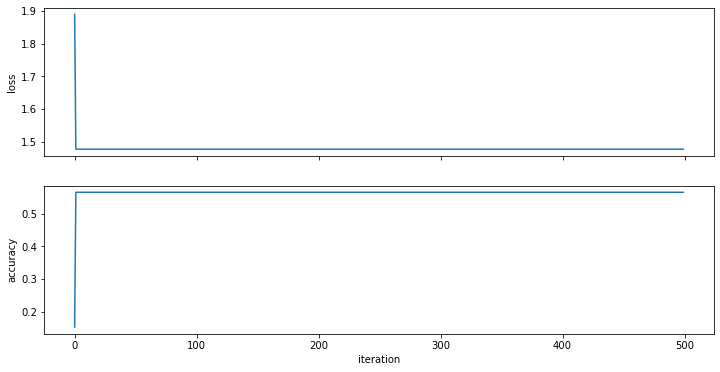

In [13]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(loss_history)
ax1.set_ylabel('loss')
ax2.plot(accuracy_history)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('iteration');

### Let's see how the model does...

In [14]:
model.eval();

In [15]:
tensor_X_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test).long()

y_pred_train = model(tensor_X_train) # 32000
y_pred_test = model(tensor_X_test)   #  8000

In [16]:
results = []

for item in y_pred_train:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)

for item in y_pred_test:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)
    
approximation = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        index = i*100 + j
        approximation[i,j] = results[index]

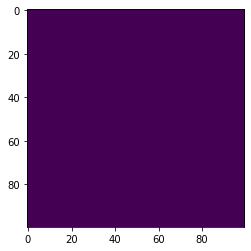

In [17]:
plt.imshow(approximation)